In [75]:
import numpy as np
import pandas as pd
import torch

# DATA PREPROCESSING (Same as Last Model)

In [76]:
## Data Preprocess + First Model ##

In [77]:
import json
with open('preprocessed.json', 'r') as file:
    data = json.load(file)

data = pd.DataFrame(data)
data['date'] = pd.to_datetime(data['date'], unit='ms')
# Combine first_name and last_name
data['player_name'] = data['first_name'] + ' ' + data['last_name']
# Remove first_name, last_name, turnover, pf, and player_id columns
data = data.drop(columns=['player_id','first_name','last_name','turnover','pf'])
# Move player_name to front
data = data[['player_name'] + data.columns.drop('player_name').tolist()]

projections = pd.read_json('prizepicks_cleaned.json')
projections = projections[~projections['name'].str.contains(r'\+')]

point_projection = projections[projections['stat_type'] == 'Points']
point_projection = point_projection[['name', 'line_score']].reset_index(drop=True)

data_and_proj = data.merge(point_projection, left_on='player_name', right_on='name', how='inner')

data_and_proj = data_and_proj.sort_values(by=['player_name', 'date'])

data_and_proj['above_threshold'] = (data_and_proj['pts'] > data_and_proj['line_score']).astype(int)

In [78]:
# Computing the last 5 averages for each player
average_estimates = ['reb', 'ast', 'pts']
for col in average_estimates:
    data_and_proj[f'{col}_avg_last_5'] = data_and_proj.groupby('player_name')[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Creating feature "on_hotstreak" to indicate if player is performing higher when compared to their average.
player_avg_pts = data_and_proj.groupby('player_name')['pts'].transform('mean')
player_avg_asts = data_and_proj.groupby('player_name')['ast'].transform('mean')
player_avg_reb = data_and_proj.groupby('player_name')['reb'].transform('mean')

# Then, compare the last 5-game average to the player's overall average and convert boolean to integers
# where (1 if on hotstreak, 0 if not)
data_and_proj['on_hotstreak_pts'] = (data_and_proj['pts_avg_last_5'] > player_avg_pts).astype(int)
data_and_proj['on_hotstreak_asts'] = (data_and_proj['ast_avg_last_5'] > player_avg_asts).astype(int)
data_and_proj['on_hotstreak_reb'] = (data_and_proj['reb_avg_last_5'] > player_avg_reb).astype(int)

In [79]:
# Scale to normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_cols = ['fgm', 'fga', 'pts','fg3m','fg3a','fta','ftm']
data_and_proj[numerical_cols] = scaler.fit_transform(data_and_proj[numerical_cols])

In [80]:
features = ["fgm", "fga", "pts", "fg3m", "fg3a", "fta",'ftm', "on_hotstreak_pts"]
X = data_and_proj[features]
y = data_and_proj["above_threshold"]

# Model 2

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification

In [128]:
# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 55],
    'max_features': ['sqrt'],
    'max_depth': [None, 1, 3],
    'min_samples_split': [4, 5, 6]
}

In [129]:
# Create the classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object with the parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Extract training and validation accuracies for each parameter combination
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
params = results['params']

Fitting 5 folds for each of 18 candidates, totalling 90 fits


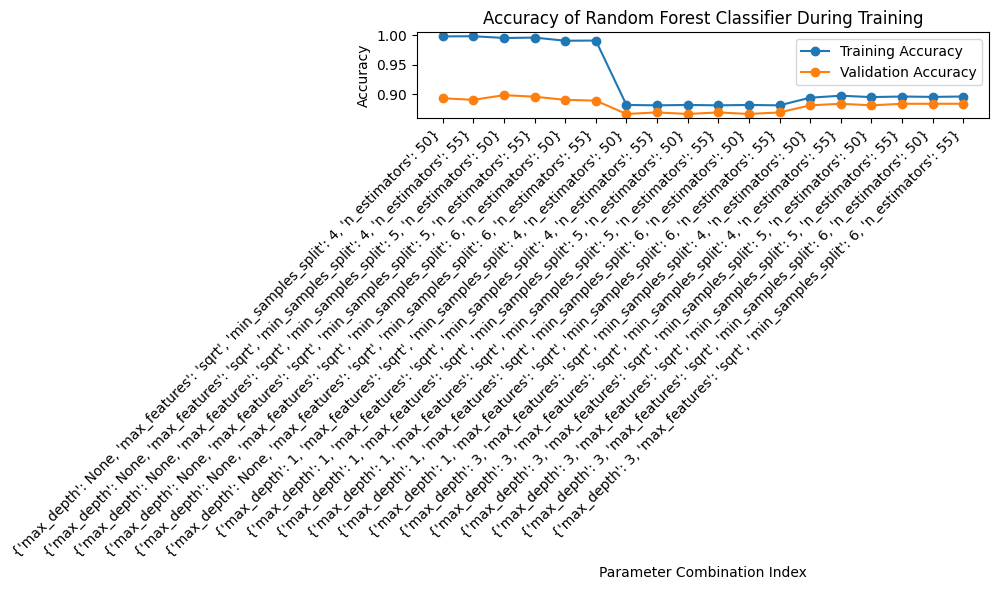

In [130]:
# Plot training and validation accuracies during Hyperparameter Tuning
plt.figure(figsize=(10, 6))
plt.plot(range(len(params)), train_scores, label='Training Accuracy', marker='o')
plt.plot(range(len(params)), val_scores, label='Validation Accuracy', marker='o')
plt.xticks(range(len(params)), [str(p) for p in params], rotation=45, ha='right')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Random Forest Classifier During Training')
plt.legend()
plt.tight_layout()
plt.show()

Where does your model fit in the fitting graph?

In [131]:
# Print the best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.90


In [132]:
# Calculate the accuracy of the best model

#Train
y_pred = grid_search.best_estimator_.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'Train set accuracy: {accuracy:.2f}')

# Test
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy:.2f}')

Train set accuracy: 0.99
Test set accuracy: 0.88


## Why difference in Train vs Test Error and Where does the Model Fit in the Fitting Graph

Train error measures how well the model fits the data it was trained on, while test error evaluates its performance on unseen data. The difference in the Train vs Test Error exists because the model has trained itself on the train data set and is more likely to be overly optimized to minimizing the error on that. When it is brought to unseen data, it would not perform as well because the model has not been optimized for that purpose. For our model, a 99% train accuracy and 88% test accuracy might indicate a bit of overfitting because the discrepancey in model performance is fairly high. However, after multiple iterations, this was one of the best performing models on the test set

On the fitting graph, this fits close to the minimum point of the test error graph. We know this because we tested different hyperparameters in the model to try and get an ideal test error. This model also lies where the train error is really low. This is because a 99% accuracy likley means that it fitting the training data very strongly


## What are the next models you are thinking of and why?

We are considering using an SVM as a future model because it is very well-designed for binary classification tasks like the one we are doing for our problem and can identify complex boundaries in high-dimensional spaces. In contrast to some of the other possible approaches, SVMs may be able to capture certain patterns in the data that other approaches cannot, allowing for better prediction. In the case where a hierarchical approach is not effective, an SVM would allow for us to consider all features, with preprocessing to convert categorical to numerical data, to make an accurate prediction.

We are also considering a decision-tree based approach because it is deterministic and probability-based, which may work well for the specific problem context here relating to betting odds. We also believe, based on our prior knowledge about basketball, that some features of our data can be used to contextualize other features, therefore allowing for us to have significant information gain across levels of the tree. Since we have both categorical and numerical data, the ability of a decision tree to handle both of these types of data is a plus of this approach.

## Conclusion section:
### What is the conclusion of your 2nd model? What can be done to possibly improve it? Note: The conclusion section should be it's own independent section. i.e. Methods: will have models 1 and 2 methods, Conclusion: will have models 1 and 2 results and discussion.

We realized from this model that in order to get the minimum test error, we needed to up overfit our training set a little bit. After optimizing our hyperparameters, we got the maximum accuracy at about 80%, which is what we previosuly capped out at. We increased the hidden layers in our random forest model and learned that it did a better job than the original model of determing hidden features and other intracies in our data. For our next model, it may be worth it to try approaches that are closer to the random forest approach in comparison to the RNN approach.